In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
import numpy as np
import torch

In [3]:
train_on_gpu = torch.cuda.is_available()

In [4]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
from traing_data import GetSequence

In [6]:
get_train = GetSequence()

In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
import tqdm

In [9]:
def train(model, model_opt, get_train):
    hidden = model.init_hidden()
    hidden = hidden.cuda()
    model.zero_grad()
    loss = 0
    for i in tqdm.tqdm(range(5000)):
        inp, target = get_train.get_train_data()
        inp = inp.to(dtype=torch.float32)
        target = target.to(dtype=torch.float32)
        inp,target = inp.cuda(), target.cuda()
        target = target.squeeze()
        output, hidden = model(inp, hidden)
        loss += criterion(output.squeeze(), target.unsqueeze(0))

    loss.backward()
    model_opt.step()

    return loss.item() / (i+1)

In [10]:
import torch
import torch.nn as nn

In [11]:
from model import RNN

In [12]:
import matplotlib.pyplot as plt

In [13]:
def evaluate(model, get_train,predict_len=10000, temperature=0.8):
    model.eval()
    hidden = model.init_hidden()
    hidden = hidden.cuda()
    inp, target = get_train.get_train_data()
    inp = inp.to(dtype=torch.float32)
    inp = inp.cuda()
    temp = list()

    # Use priming string to "build up" hidden state
    for p in range(inp.shape[0]):
        _, hidden = model(inp, hidden)
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        temp.append(output.squeeze().tolist())
    data = np.array(temp)
    plt.plot(data)
    plt.show()
    model.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

RNN(
  (liner): Linear(in_features=5000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.3)
  (gru): GRU(1000, 1000, num_layers=5)
  (decoder): Linear(in_features=1000, out_features=5000, bias=True)
  (liner2): Linear(in_features=5000, out_features=1, bias=True)
  (softmax): LogSoftmax()
)


100%|██████████| 5000/5000 [07:32<00:00, 11.04it/s]


 45s (20 2%) 0.2524]


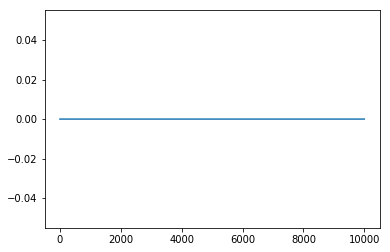

None 



100%|██████████| 5000/5000 [07:16<00:00, 11.46it/s]


 9s (40 4%) 0.2545]


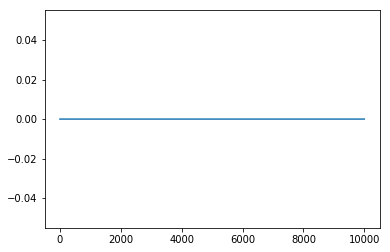

  0%|          | 0/5000 [00:00<?, ?it/s]

None 



  5%|▌         | 260/5000 [00:22<10:34,  7.47it/s]

In [ ]:
n_epochs = 1000
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.01

rnn = RNN(n_layers=5)
rnn.cuda()
print(rnn)
rnn_opt = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.MSELoss().cuda()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(rnn, rnn_opt, get_train)       
    loss_avg += loss

    if epoch % 20 == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(rnn, get_train), '\n')
        torch.save(rnn.state_dict(), 'model_cifar.pt')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

In [ ]:
nn.Dropout(p=0.3)